# Libraries and Data Load

In [ ]:
# we import libraries useful for file management, audio elaboration and data analysis
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from time import time
import zipfile
from shutil import copyfile
import random as python_random

# we import the library tensorflow where we take keras, which is an API extremely useful to build and train neural networks as in our case.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # tool used to apply transformations to images

# we import libraries from scikit-learn in order to apply classification with Support Vector Machine
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # metrics to evaluate our model performance and tools to show graphically the results
from sklearn.model_selection import train_test_split # tool to divide data in training and test

In [ ]:
# we set the seed to ensure the reproducibility of the results
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Percorso del file zip su Google Drive
zip_path = '/content/drive/MyDrive/DSIM Project/animal.zip'

# Percorso locale di estrazione (all'interno della VM, che è temporanea)
extract_to = '/content/animal'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print('File estratti in locale')


File estratti in locale


In [ ]:
# we generate data paths with labels
train_data_dir = '/content/animal/Animals'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# we concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

# we divide the dataset in training (80%) and the remaining 20% is divided in half among test and validation set
train_df, validation = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(validation, train_size=0.5, shuffle = True, random_state=123)

# we define the image size and batch size for training
batch_size = 16
img_size = (256, 256)

# we create ImageDataGenerators for training, validation, and testing
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# dataset for training
train_dataset = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

# dataset for validation
validation_dataset = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

# dataset for test
test_dataset = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

g_dict = train_dataset.class_indices  # we define dictionary {'class': index}
classes = list(g_dict.keys())  # we define list of dictionary's keys (classes)

# we display some images with labels
images, labels = next(train_dataset)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# CNN from scracth

## Simple Model

In [ ]:
num_classes = 3 # our 3 classes "dogs", "cats" and "snakes"

# we define the input of the model with dimensions 256x256 and 3 channels (RGB images)
inputs = keras.Input((256,256,3))

# intialize the inputs
x = inputs

# first convolutional layer with 32 filters, each of dimension 3x3, and padding="same" to keep invariate dimensions
x = keras.layers.Conv2D(32,3, padding = "same")(x)
x = keras.layers.Activation("relu")(x) # activation function ReLU

# max pooling to reduce spatial dimension
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# second convolutional layer with 64 filters, each of dimension 3x3, and padding="same" to keep invariate dimensions
x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.Activation("relu")(x) # activation function ReLU

# global max pooling to reduce the number of parameters and prevent overfitting
x = keras.layers.GlobalMaxPooling2D()(x)

# dense layer with activation functions softmax
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net_simple = keras.Model(inputs, outputs) # we create the final model with defined input and output

In [ ]:
# we print the summary
net_simple.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 86, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 86, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 86, 86, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,587 (76.51 KB)

 Trainable params: 19,587 (76.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# we compile the model
net_simple.compile(loss=keras.losses.categorical_crossentropy, # we define the loss function
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001), # we define the optimizer
            metrics=['accuracy']) # we use accuracy to check the performance

On this part we configure the model for training:

*   loss: loss function that will be minimizedloss: loss function that will be minimized
*   optimizer: algorithm that changes the attributes of model to reduce the loss function based on the learning rate, that is the width of the steps
*   metrics: used to judge the model performance, in this case by the accuracy

In [ ]:
# progression through the epochs
history = net_simple.fit(train_dataset,
          epochs=40,
          validation_data=validation_dataset);

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.3863 - loss: 16.4519 - val_accuracy: 0.4767 - val_loss: 3.2526
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5342 - loss: 1.5624 - val_accuracy: 0.4600 - val_loss: 1.2479
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5533 - loss: 1.0569 - val_accuracy: 0.5567 - val_loss: 1.1095
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6101 - loss: 0.8981 - val_accuracy: 0.6500 - val_loss: 0.8134
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6290 - loss: 0.8152 - val_accuracy: 0.5900 - val_loss: 1.0391
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6580 - loss: 0.7546 - val_accuracy: 0.6400 - val_loss: 0.8079
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6807 - loss: 0.7063 - val_accuracy: 0.5667 - val_loss: 1.0315
Epoch 8/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6933 - loss: 0.6506 - val_accuracy: 0.56

We can see that the training can reach good results but the validation is too low, the history and the plots shows that the model is in overfitting

### Evaluation

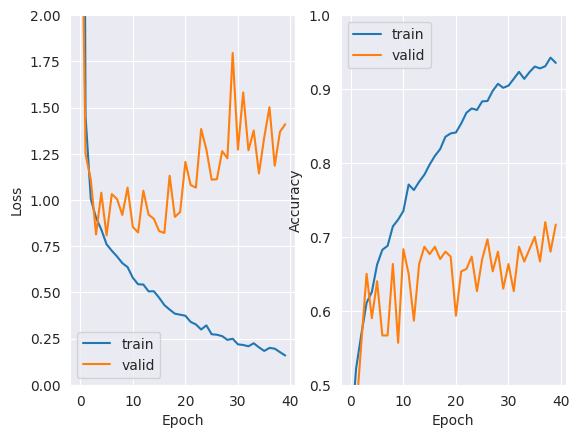

In [ ]:
# we plot the history through the epochs to see the results
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
# we print the results of loss and accuracy
loss, accuracy = net_simple.evaluate(test_dataset)


print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6071 - loss: 1.8611
Test Loss: 1.7971421480178833
Test Accuracy: 0.6366666555404663


The evaluation from the test set shows worse result then the validation

### Inference

In [ ]:
# Generate predictions
test_dataset.reset()  # we reset the generator to ensure it starts from the beginning
predictions = net_simple.predict(test_dataset)#, steps=test_dataset.samples // test_dataset.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# we get the true labels
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [ ]:
# we print the report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

        cats       0.48      0.77      0.59        94
        dogs       0.65      0.31      0.42        99
      snakes       0.85      0.82      0.84       107

    accuracy                           0.64       300
   macro avg       0.66      0.63      0.62       300
weighted avg       0.67      0.64      0.62       300



In [ ]:
# as we can see the model achieves an accuracy of 64%, more specifically it is very good on predicting snakes. The model is not good in identifying dogs, as the recall assumes a
# very low velue (0.31), producing lot of false negatives and same discourse for cats where the model has a very low precision in identifying cats (precision = 0.48).
# Generically the model has a good accuracy but some improvements can be made specially with cats and dogs.

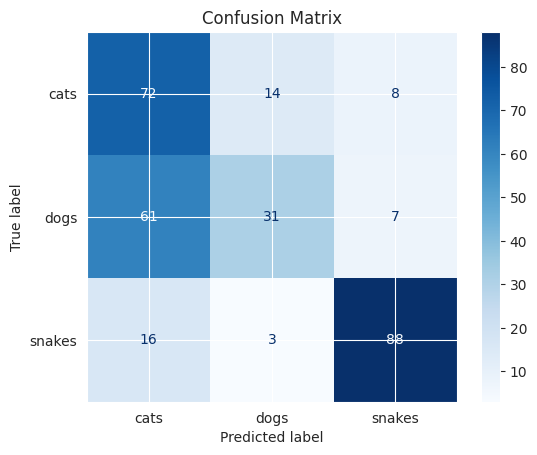

In [ ]:
# we display the results with the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In the inference part we can see that the model has more difficult to distinguish dogs from cats

## Enhanced Model

In this model, based on the first one, we'll add regularization and batch normalization to avoid overfitting

In [ ]:
# basically we proceed as before but this time we add at each layer the regularizer and the batch normalization with the intent to avoid overfitting (penalty=0.01).
inputs = keras.Input((256,256,3))
x = inputs
x = keras.layers.Conv2D(32,3, padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
net_enh = keras.Model(inputs, outputs)

In [ ]:
# this is the summary
net_enh.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 86, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 86, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 86, 86, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 86, 86, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,971 (78.01 KB)

 Trainable params: 19,779 (77.26 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# we compile the model defining as before loss function, optimizer and metric
net_enh.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

We add also a callback to monitor the value of the loss function to avoid the model overfit and stop early

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# we print the history through the epochs
history = net_enh.fit(train_dataset,
          epochs=40,
          validation_data=validation_dataset,
            callbacks=[callback]);

Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.4463 - loss: 1.8677 - val_accuracy: 0.6033 - val_loss: 1.3102
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6325 - loss: 1.2126 - val_accuracy: 0.5267 - val_loss: 1.3147
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6678 - loss: 1.0713 - val_accuracy: 0.6067 - val_loss: 1.0894
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6877 - loss: 0.9590 - val_accuracy: 0.6900 - val_loss: 0.9106
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6946 - loss: 0.9180 - val_accuracy: 0.5733 - val_loss: 1.0552
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7008 - loss: 0.8742 - val_accuracy: 0.7400 - val_loss: 0.8372
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7315 - loss: 0.8298 - val_accuracy: 0.7333 - val_loss: 0.8025
Epoch 8/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7492 - loss: 0.7917 - val_accu

The results are slightly better in terms of overfit than before and regularizating it we loss some accuracy on the training

### Evaluation

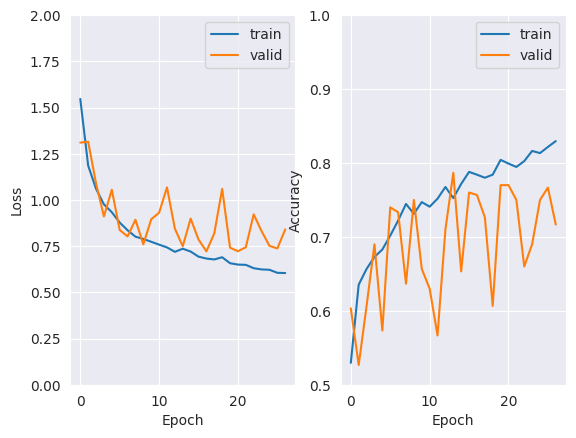

In [ ]:
# this are the results displayed
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
loss, accuracy = net_enh.evaluate(test_dataset)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6204 - loss: 1.0293
Test Loss: 0.9974238872528076
Test Accuracy: 0.6299999952316284


The evalutation are quite the same as the first model

### Inference

In [ ]:
# we generate predictions
test_dataset.reset()  # Reset the generator to ensure it starts from the beginning
predictions = net_enh.predict(test_dataset)#, steps=test_dataset.samples // test_dataset.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# we get the true labels
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [ ]:
# we print as usual the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

        cats       0.46      0.98      0.63        94
        dogs       0.94      0.30      0.46        99
      snakes       0.97      0.63      0.76       107

    accuracy                           0.63       300
   macro avg       0.79      0.64      0.62       300
weighted avg       0.80      0.63      0.62       300



In [ ]:
# even if we can note improvements on some classes (precision for dogs and snakes or recall for cats) we can still see some problems with the dogs and the general performance of
# the model. Some improvements can still be made.

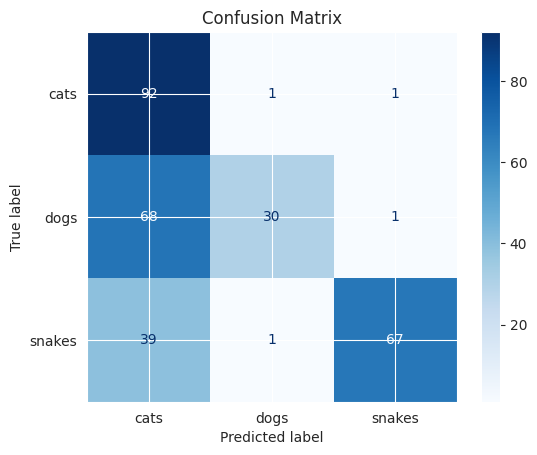

In [ ]:
# we plot the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Enhanced model 2

Seeing the results before, we decide to construct a deeper model in order to try to gain the maximum that our observations can give

In [ ]:
# we proceed as before but change the value of the penalty (0.1)
inputs = keras.Input((256,256,3))
x = inputs

x = keras.layers.Conv2D(32,3, padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32,3, padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Conv2D(64,3, padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
net_deep = keras.Model(inputs, outputs)

In [ ]:
net_deep.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 86, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 86, 86, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 86, 86, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 86, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 86, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 86, 86, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 86, 86, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_6               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,347 (114.64 KB)

 Trainable params: 29,091 (113.64 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
net_deep.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
            metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = net_deep.fit(train_dataset,
          epochs=40,
          validation_data=validation_dataset,
            callbacks=[callback]);

Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4267 - loss: 9.6629 - val_accuracy: 0.4067 - val_loss: 9.0565
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5937 - loss: 8.5398 - val_accuracy: 0.5567 - val_loss: 8.1193
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6477 - loss: 7.7796 - val_accuracy: 0.6133 - val_loss: 7.3876
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6896 - loss: 7.1234 - val_accuracy: 0.5767 - val_loss: 6.8798
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7222 - loss: 6.5264 - val_accuracy: 0.6167 - val_loss: 6.3253
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7322 - loss: 6.0508 - val_accuracy: 0.6133 - val_loss: 5.9205
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7495 - loss: 5.6202 - val_accuracy: 0.5933 - val_loss: 5.5560
Epoch 8/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7779 - loss: 5.2076 - val_acc

### Evaluation

In this case we figure out that a deeper model gives worse results, raising the overfitting.

So next we'll try with data augmentation

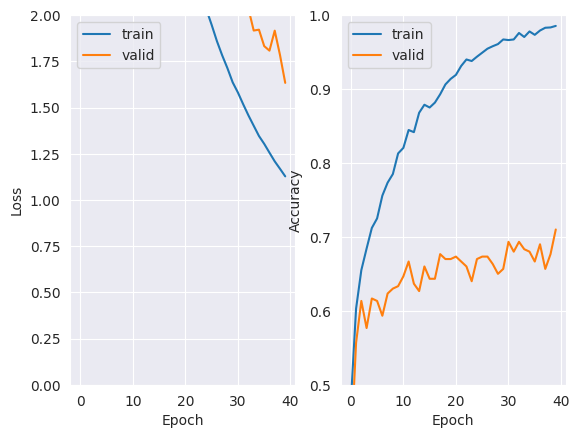

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
loss, accuracy = net_deep.evaluate(test_dataset)


print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7353 - loss: 1.6121
Test Loss: 1.6393911838531494
Test Accuracy: 0.7266666889190674


By testing this model we see that it got higher accuracy than the other. So let's take a look on the inference to see if the problem of distinguishing dogs from cats persist

### Inference

In [ ]:
# we generate predictions
test_dataset.reset()  # we reset the generator to ensure it starts from the beginning
predictions = net_deep.predict(test_dataset, steps=test_dataset.samples // test_dataset.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# we get the true labels
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

        cats       0.63      0.69      0.66        94
        dogs       0.66      0.62      0.64        99
      snakes       0.88      0.86      0.87       107

    accuracy                           0.73       300
   macro avg       0.72      0.72      0.72       300
weighted avg       0.73      0.73      0.73       300



In [ ]:
# As we can see the model is getting better try after try; it seems to achieve better results with dogs and cats even if they are not good as the results obtained with the snakes.
# Also the macro averages and the weighted averages have a good value with the accuracy that is equal to 73%. One final step is to apply data augmentation.

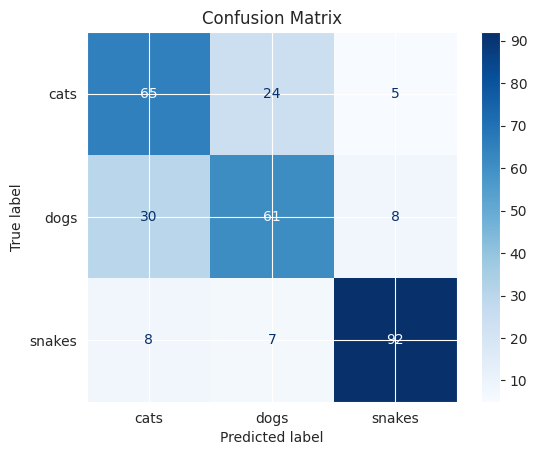

In [ ]:
# results plotted through the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# CNN and Data Augmentation

In [ ]:
# we define a data generator to train the model for data augmentation.
train_aug = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(300,300), class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 2400 validated image filenames belonging to 3 classes.


To compute the data augmentation we have to set larger size to the image due to RandomCrop layer

In [ ]:
inputs = keras.Input((None,None,3))

x = inputs

x = keras.layers.RandomCrop(256, 256)(x)
x = keras.layers.RandomFlip(mode='horizontal')(x)
x = keras.layers.RandomContrast(0.1)(x)

x = keras.layers.Conv2D(16, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('selu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('selu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('selu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('selu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="selu", kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)

outputs = keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
net_aug = keras.Model(inputs, outputs)

In [ ]:
net_aug.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_crop_4 (RandomCrop)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_4 (RandomFlip)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_4 (RandomContrast)   │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 256, 256, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 256, 256, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 86, 86, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 86, 86, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 86, 86, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 86, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 29, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 65,571 (256.14 KB)

 Trainable params: 65,219 (254.76 KB)

 Non-trainable params: 352 (1.38 KB)

In [ ]:
net_aug.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = net_aug.fit(train_aug,
          epochs=40,
          validation_data=validation_dataset,
            callbacks=[callback]);

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.4894 - loss: 21.6295 - val_accuracy: 0.5067 - val_loss: 19.3338
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.6120 - loss: 18.5502 - val_accuracy: 0.5833 - val_loss: 16.9419
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6774 - loss: 16.3776 - val_accuracy: 0.6067 - val_loss: 14.9907
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6850 - loss: 14.4644 - val_accuracy: 0.6100 - val_loss: 13.3194
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6951 - loss: 12.8549 - val_accuracy: 0.6867 - val_loss: 11.8161
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7168 - loss: 11.4190 - val_accuracy: 0.6633 - val_loss: 10.5306
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7378 - loss: 10.1858 - val_accuracy: 0.7067 - val_loss: 9.4328
Epoch 8/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7450 - loss: 9.1220 - val_a

### Evaluation

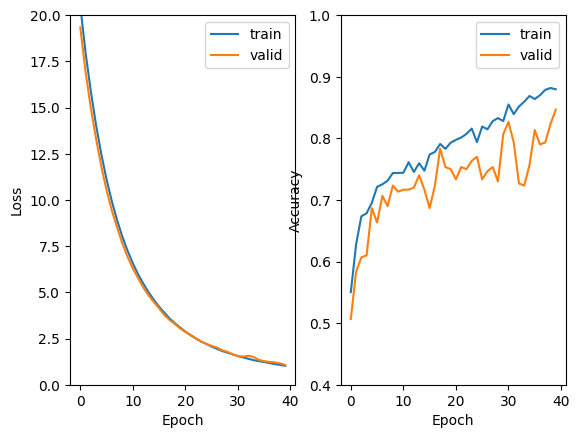

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 20.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.4, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
loss, accuracy = net_aug.evaluate(test_dataset)


print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.8971 - loss: 0.9974
Test Loss: 1.0258851051330566
Test Accuracy: 0.8866666555404663


With the data augmentation we reach great results. The most important change was that to swap the activation function from "relu" to "selu", because the first suffer of the typical vanishing gradiant instead of the second that has a self-normalizing property, this lead the model to stabilize the training process and to a faster convergence

### Inference

In [ ]:
# Generate predictions
test_dataset.reset()  # Reset the generator to ensure it starts from the beginning
predictions = net_aug.predict(test_dataset)#, steps=test_dataset.samples // test_dataset.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step


In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

        cats       0.93      0.82      0.87        99
        dogs       0.79      0.96      0.87       107
      snakes       0.99      0.87      0.93        94

    accuracy                           0.89       300
   macro avg       0.90      0.88      0.89       300
weighted avg       0.90      0.89      0.89       300



In [ ]:
# Finally as we can see after data augmentation we improved our model that now achieves very good results in all the classes. We have an overall accuracy of 89% and macro averages
# and weighted averages all close to 0.90. In conclusion we can say that even if the model steel obtain greater results with the class "snakes", now it is able to detect efficiently
# also the other classes.

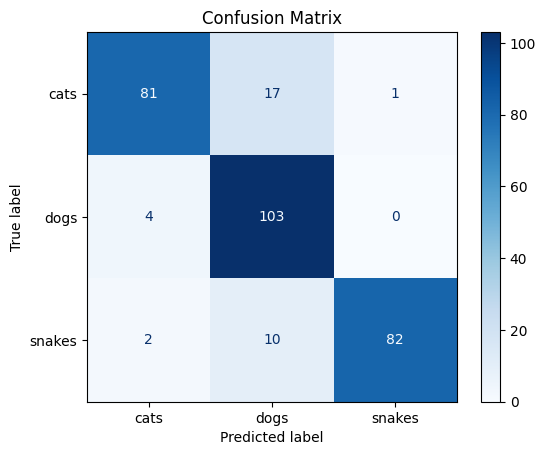

In [ ]:
# finally we plot the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Model save

In [ ]:
# Save the entire model
net_aug.save('/content/drive/MyDrive/DSIM Project/best_model.h5')